In [1]:
import math
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
from scipy.integrate import quad, trapz

import scipy.stats
import scipy.optimize
from scipy.signal import find_peaks

%pylab inline

from lmfit import minimize, Parameters, Model, fit_report

S_n = 7.246 #энергия отрыва нейтрона

total_GT = 55.54

Populating the interactive namespace from numpy and matplotlib


In [2]:
def gauss(x, mu, sigma, k):
    return k*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

def line(x, a, b):
    return a*x+b

def breit_vigner2(x, M, w = 11.3, alpha = 0.018):
    G = alpha * (w ** 2) + 1
    #G = alpha * (w ** 2)
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

def breit_vigner3(x, M, w,  G1):
    G = G1
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

def breit_vigner4(x, M, w,  G1):
    a = M/(2*np.pi*G1)
    b = 1 + np.square(2*(x-w)/G1)
    return np.round(a/b, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

def QFC_back4(x, E_qf, N_0, Q_EC, S_p, E_projectile):
    W = 22
    T = 100
    E_t_gs = E_projectile - Q_EC
    E_0 = E_t_gs - S_p
    E = E_t_gs - x
    
    values = N_0 * ( 1 - np.exp((E-E_0)/T) )/( 1 + ((E-E_qf)/W)**2)
    values_more0 = values[ np.where(values>0) ]
    beginning = np.zeros((len(x)-len(values_more0)))
    return np.concatenate((beginning, values_more0))

In [3]:
data_to_fit_x = np.linspace(0,25, 4000)

## data from 1999

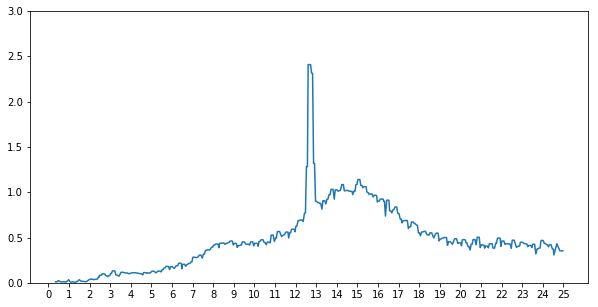

In [4]:
data1985 = pd.read_csv('../B(GT) peaks processing/recognition/Xe127/1999_fig2.csv', 
                      sep=';', decimal=',', names=['x', 'y'])
#data1985['x'] = -data1985['x'] + 120

plt.figure(figsize=(10,5))
plt.plot(data1985['x'].values, data1985['y'].values)
plt.xticks(np.arange(0,26,1))
plt.ylim(0,3)
plt.show()

In [5]:
total_mod = Model(breit_vigner3,prefix='pigmy1_') \
+Model(breit_vigner3, prefix='pigmy2_') \
+Model(breit_vigner3, prefix='IAS_') \
+Model(breit_vigner3, prefix='GTR_') \
+Model(QFC_back4, prefix='QFC_')

total_mod.set_param_hint('pigmy1_w', value=9, min=5, max=11)
total_mod.set_param_hint('pigmy1_G1', value=0.1, min=0.1, max=1.5)
total_mod.set_param_hint('pigmy1_M', value=5, min=0.1, max=10)

total_mod.set_param_hint('pigmy2_w', value=4, min=2, max=5)
total_mod.set_param_hint('pigmy2_G1', value=0.1, min=0.1, max=1.5)
total_mod.set_param_hint('pigmy2_M', value=1, min=0.1, max=2)

total_mod.set_param_hint('IAS_w', value=13.5, min=12, max=14)
total_mod.set_param_hint('IAS_G1', value=0.1, min=0.01, max=3)
total_mod.set_param_hint('IAS_M', value=1, min=0.1, max=20)

total_mod.set_param_hint('GTR_w', value=15, min=11, max=16)
total_mod.set_param_hint('GTR_G1', value=2, min=2, max=5)
total_mod.set_param_hint('GTR_M', value=5, min=0.1, max= 30)

total_mod.set_param_hint('QFC_E_qf', value=400, min=50, max=420)
total_mod.set_param_hint('QFC_N_0', value=8, min=1, max=15)
total_mod.set_param_hint('QFC_Q_EC', value=0.662, vary=False)
total_mod.set_param_hint('QFC_S_p', value=7.699, vary=False)
total_mod.set_param_hint('QFC_E_projectile', value=159.1, vary=False)

pars = total_mod.make_params()

total_mod_result = total_mod.fit(data1985['y'].values, pars, x=data1985['x'].values, 
                                 method='differential_evolution')

print(total_mod_result.fit_report())

[[Model]]
    ((((Model(breit_vigner3, prefix='pigmy1_') + Model(breit_vigner3, prefix='pigmy2_')) + Model(breit_vigner3, prefix='IAS_')) + Model(breit_vigner3, prefix='GTR_')) + Model(QFC_back4, prefix='QFC_'))
[[Fit Statistics]]
    # function evals   = 38896
    # data points      = 449
    # variables        = 14
    chi-square         = 1.520
    reduced chi-square = 0.003
    Akaike info crit   = -2526.038
    Bayesian info crit = -2468.539
[[Variables]]
    pigmy1_M:           0.42173095 (init= 5)
    pigmy1_w:           8.56827091 (init= 9)
    pigmy1_G1:          1.47246626 (init= 0.1)
    pigmy2_M:           0.10014822 (init= 1)
    pigmy2_w:           3.31413627 (init= 4)
    pigmy2_G1:          1.49946354 (init= 0.1)
    IAS_M:              0.24419760 (init= 1)
    IAS_w:              12.7132931 (init= 13.5)
    IAS_G1:             0.12170929 (init= 0.1)
    GTR_M:              2.58557886 (init= 5)
    GTR_w:              14.8358741 (init= 15)
    GTR_G1:             2.7923

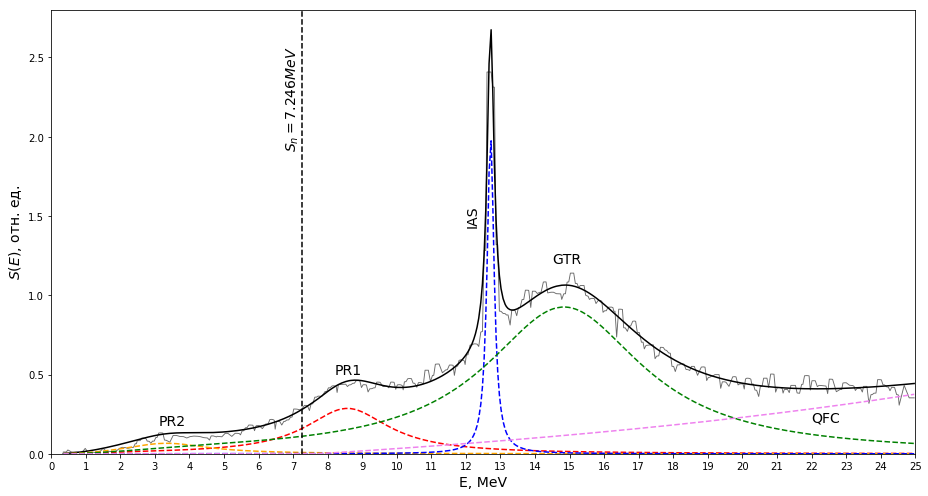

In [6]:
total_mod_comps = total_mod_result.eval_components()

plt.figure(figsize=(13,7))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(data1985['x'].values, data1985['y'].values, 'dimgrey', linewidth=0.9, label='experimental data')
plt.plot(data1985['x'].values, total_mod_result.best_fit, 'k', ls='-', label='total fit')
plt.plot(data1985['x'].values, total_mod_comps['pigmy1_'], 'red', ls='--', label='pigmy1',)
plt.plot(data1985['x'].values, total_mod_comps['pigmy2_'], 'orange', ls='--', label='pigmy2')
plt.plot(data1985['x'].values, total_mod_comps['IAS_'], 'b--', label='IAS')
plt.plot(data1985['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.plot(data1985['x'].values, total_mod_comps['QFC_'], 'violet', ls='--', label='QFC')

plt.axvline(S_n, c='black', ls='--',)
plt.text(S_n-0.5, 2.5, '$S_{n}=7.246 MeV$', rotation=90, fontsize=14)

plt.text(14.5, 1.2, 'GTR',  fontsize=14)
plt.text(22, 0.2, 'QFC',  fontsize=14)
plt.text(12.0, 1.5, 'IAS',  fontsize=14, rotation=90)
plt.text(3.1, 0.18, 'PR2',  fontsize=14)
plt.text(8.2, 0.5, 'PR1',  fontsize=14)

plt.xlabel('E, MeV',fontsize=14)
#plt.ylabel('S(E), 1/MeV')
plt.ylabel('$S(E)$, отн. ед.', rotation=90, fontsize=14)
plt.ylim(0,2.8)
plt.xlim(0,25)
plt.xticks(np.arange(0,26,1))
#plt.show()
plt.tight_layout()
plt.savefig('Xe127_decomposition_BW.png', format='png', dpi=500)
#plt.show()

In [7]:
total_mod_gauss = Model(gauss,prefix='pigmy1_') \
+Model(gauss, prefix='pigmy2_') \
+Model(gauss, prefix='IAS_') \
+Model(gauss, prefix='GTR_') \
+Model(QFC_back4, prefix='QFC_')

total_mod_gauss.set_param_hint('pigmy1_mu', value=9, min=5, max=11)
total_mod_gauss.set_param_hint('pigmy1_sigma', value=0.1, min=0.1, max=3)
total_mod_gauss.set_param_hint('pigmy1_k', value=5, min=0.1, max=10)

total_mod_gauss.set_param_hint('pigmy2_mu', value=4, min=0.1, max=6)
total_mod_gauss.set_param_hint('pigmy2_sigma', value=0.1, min=0.1, max=1.0)
total_mod_gauss.set_param_hint('pigmy2_k', value=1, min=0.1, max=2)

total_mod_gauss.set_param_hint('IAS_mu', value=13.5, min=12, max=14)
total_mod_gauss.set_param_hint('IAS_sigma', value=0.1, min=0.01, max=3)
total_mod_gauss.set_param_hint('IAS_k', value=1, min=0.1, max=10)

total_mod_gauss.set_param_hint('GTR_mu', value=15, min=11, max=16)
total_mod_gauss.set_param_hint('GTR_sigma', value=2, min=2, max=5)
total_mod_gauss.set_param_hint('GTR_k', value=5, min=0.1, max= 30)

total_mod_gauss.set_param_hint('QFC_E_qf', value=400, min=50, max=420)
total_mod_gauss.set_param_hint('QFC_N_0', value=8, min=1, max=10)
total_mod_gauss.set_param_hint('QFC_Q_EC', value=0.662, vary=False)
total_mod_gauss.set_param_hint('QFC_S_p', value=7.699, vary=False)
total_mod_gauss.set_param_hint('QFC_E_projectile', value=159.1, vary=False)

pars_gauss = total_mod_gauss.make_params()

total_mod_gauss_result = total_mod_gauss.fit(data1985['y'].values, pars_gauss, x=data1985['x'].values, 
                                 method='differential_evolution')

print(total_mod_gauss_result.fit_report())

[[Model]]
    ((((Model(gauss, prefix='pigmy1_') + Model(gauss, prefix='pigmy2_')) + Model(gauss, prefix='IAS_')) + Model(gauss, prefix='GTR_')) + Model(QFC_back4, prefix='QFC_'))
[[Fit Statistics]]
    # function evals   = 58471
    # data points      = 449
    # variables        = 14
    chi-square         = 1.047
    reduced chi-square = 0.002
    Akaike info crit   = -2693.426
    Bayesian info crit = -2635.927
[[Variables]]
    pigmy1_mu:          8.39579424 (init= 9)
    pigmy1_sigma:       1.83661450 (init= 0.1)
    pigmy1_k:           0.36332125 (init= 5)
    pigmy2_mu:          3.58106992 (init= 4)
    pigmy2_sigma:       1          (init= 0.1)
    pigmy2_k:           0.10732079 (init= 1)
    IAS_mu:             12.7157226 (init= 13.5)
    IAS_sigma:          0.11628545 (init= 0.1)
    IAS_k:              1.83254100 (init= 1)
    GTR_mu:             14.6104688 (init= 15)
    GTR_sigma:          2.16244015 (init= 2)
    GTR_k:              0.75932232 (init= 5)
    QFC_E_qf:    

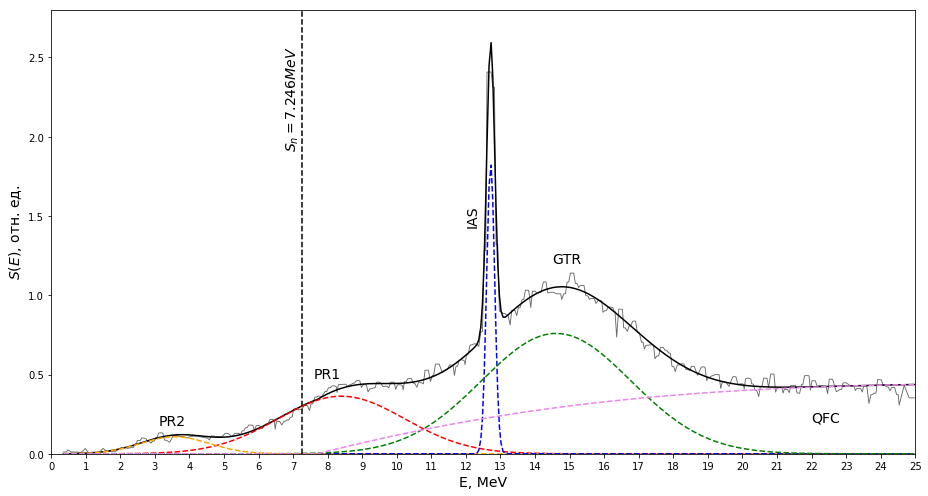

In [8]:
total_mod_gauss_comps = total_mod_gauss_result.eval_components()

plt.figure(figsize=(13,7))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(data1985['x'].values, data1985['y'].values, 'dimgrey', linewidth=0.9, label='experimental data')
plt.plot(data1985['x'].values, total_mod_gauss_result.best_fit, 'k', ls='-', label='total fit')
plt.plot(data1985['x'].values, total_mod_gauss_comps['pigmy1_'], 'red', ls='--', label='pigmy1',)
plt.plot(data1985['x'].values, total_mod_gauss_comps['pigmy2_'], 'orange', ls='--', label='pigmy2')
plt.plot(data1985['x'].values, total_mod_gauss_comps['IAS_'], 'b--', label='IAS')
plt.plot(data1985['x'].values, total_mod_gauss_comps['GTR_'], 'g--', label='GTR')
plt.plot(data1985['x'].values, total_mod_gauss_comps['QFC_'], 'violet', ls='--', label='QFC')

plt.axvline(S_n, c='black', ls='--',)
plt.text(S_n-0.5, 2.5, '$S_{n}=7.246 MeV$', rotation=90, fontsize=14)

plt.text(14.5, 1.2, 'GTR',  fontsize=14)
plt.text(22, 0.2, 'QFC',  fontsize=14)
plt.text(12.0, 1.5, 'IAS',  fontsize=14, rotation=90)
plt.text(3.1, 0.18, 'PR2',  fontsize=14)
plt.text(7.6, 0.48, 'PR1',  fontsize=14)

plt.xlabel('E, MeV',fontsize=14)
#plt.ylabel('S(E), 1/MeV')
plt.ylabel('$S(E)$, отн. ед.', rotation=90, fontsize=14)
plt.ylim(0,2.8)
plt.xlim(0,25)
plt.xticks(np.arange(0,26,1))
#plt.show()
plt.tight_layout()
plt.savefig('Xe127_decomposition_gauss.png', format='png', dpi=500)

In [9]:
output = pd.DataFrame(data={'Ex, MeV':data1985['x'].values,
                            'y':total_mod_gauss_comps['pigmy1_']+
                           total_mod_gauss_comps['pigmy2_']+
                           total_mod_gauss_comps['GTR_']})
output.head()

,"Ex, MeV",y
0,0.350987,0.000607
1,0.434621,0.000790
2,0.482412,0.000916
3,0.589942,0.001268
4,0.733315,0.001921


In [10]:
#output.to_excel('127Xe_gauss.xls', index=False)

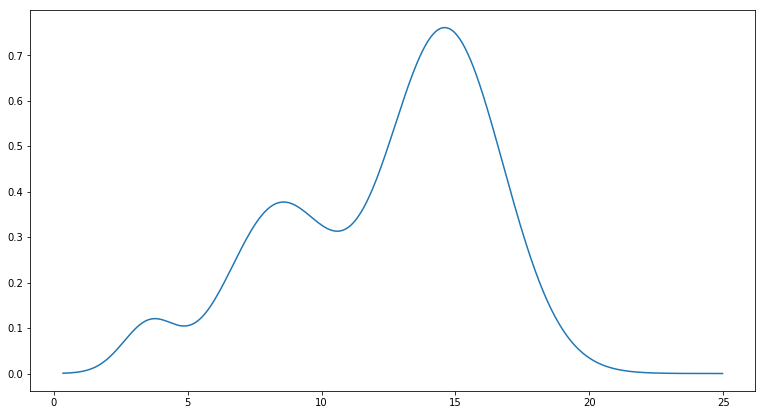

In [11]:
plt.figure(figsize=(13,7))
plt.plot(output['Ex, MeV'].values, output['y'].values)
plt.show()

In [12]:
10e01

100.0

In [13]:
bgt_full = pd.read_csv('../B(GT) peaks processing/recognition/Xe127/1999_bgt_full.csv', 
                      sep=';', decimal=',', names=['x', 'y'])
bgt_0_5 = pd.read_csv('../B(GT) peaks processing/recognition/Xe127/1999_bgt_0_5l.csv', 
                      sep=';', decimal=',', names=['x', 'y'])

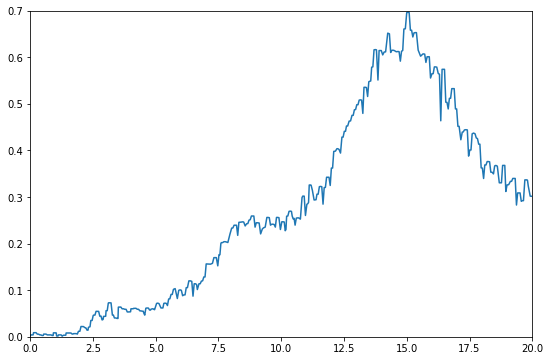

In [14]:
bgt = bgt_0_5.append(bgt_full[bgt_full['x']>5])

plt.figure(figsize=(9,6))
plt.plot(bgt['x'].values, bgt['y'].values)
plt.xlim(0,20)
plt.ylim(0,0.7)
plt.show()

In [15]:
trapz(bgt['y'].values, bgt['x'].values)

5.463277472256921

(0, 7)

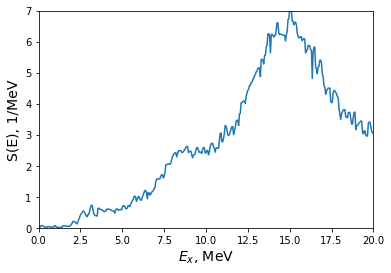

In [16]:
y_bgt = bgt['y'].values / trapz(bgt['y'].values, bgt['x'].values) \
* total_GT
#y_bgt_border = border_func(bgt['x'].values, y_bgt, S_n)

x_values = np.linspace(0,20, 401)
y_bgt_new = np.interp(x_values, bgt['x'].values, y_bgt)

plt.plot(x_values, y_bgt_new, )
plt.xlabel('$E_{x}$, MeV', fontsize=14)
plt.ylabel('S(E), 1/MeV', fontsize=14)
plt.xlim(0,20)
plt.ylim(0,7)

In [17]:
total_mod = Model(breit_vigner3,prefix='pigmy1_') \
+Model(breit_vigner3, prefix='pigmy2_') \
+Model(breit_vigner3, prefix='GTR_') \

total_mod.set_param_hint('pigmy1_w', value=9, min=5, max=11)
total_mod.set_param_hint('pigmy1_G1', value=0.1, min=0.1, max=1.5)
total_mod.set_param_hint('pigmy1_M', value=5, min=0.1, max=10)

total_mod.set_param_hint('pigmy2_w', value=4, min=2, max=5)
total_mod.set_param_hint('pigmy2_G1', value=0.1, min=0.1, max=1.5)
total_mod.set_param_hint('pigmy2_M', value=1, min=0.1, max=2)

total_mod.set_param_hint('GTR_w', value=15, min=11, max=16)
total_mod.set_param_hint('GTR_G1', value=2, min=2, max=5)
total_mod.set_param_hint('GTR_M', value=5, min=0.1, max= 30)

pars = total_mod.make_params()

total_mod_result = total_mod.fit(y_bgt_new, pars, x=x_values, 
                                 method='differential_evolution')

print(total_mod_result.fit_report())

[[Model]]
    ((Model(breit_vigner3, prefix='pigmy1_') + Model(breit_vigner3, prefix='pigmy2_')) + Model(breit_vigner3, prefix='GTR_'))
[[Fit Statistics]]
    # function evals   = 7301
    # data points      = 401
    # variables        = 9
    chi-square         = 20.465
    reduced chi-square = 0.052
    Akaike info crit   = -1175.066
    Bayesian info crit = -1139.120
[[Variables]]
    pigmy1_M:    0.85410807 (init= 5)
    pigmy1_w:    8.32409932 (init= 9)
    pigmy1_G1:   0.84732692 (init= 0.1)
    pigmy2_M:    0.10319047 (init= 1)
    pigmy2_w:    2.93506015 (init= 4)
    pigmy2_G1:   0.48996448 (init= 0.1)
    GTR_M:       24.4329830 (init= 5)
    GTR_w:       15.0957357 (init= 15)
    GTR_G1:      3.83110131 (init= 2)



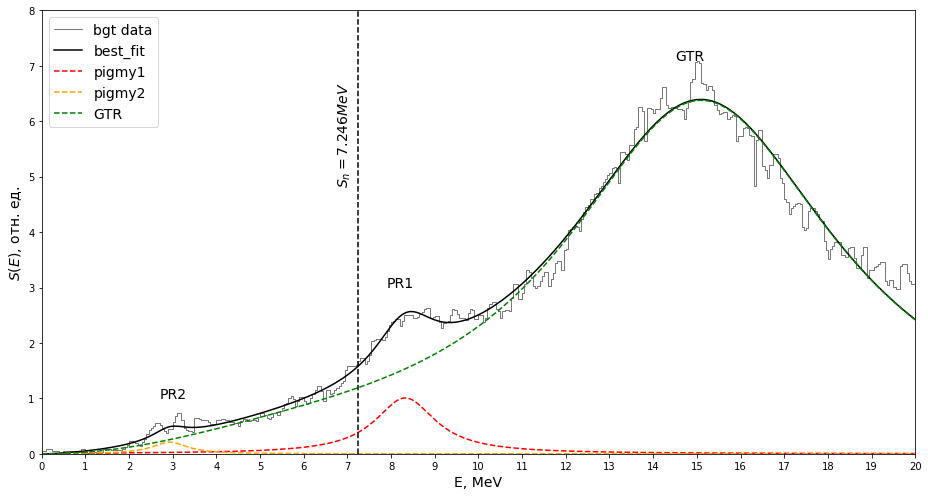

In [22]:
total_mod_comps = total_mod_result.eval_components()

plt.figure(figsize=(13,7))
#plt.plot(data['x'].values, data['y'].values)
plt.step(x_values, y_bgt_new, 'dimgrey', linewidth=0.9, label='bgt data')
plt.plot(x_values, total_mod_result.best_fit, 'k', ls='-', label='best_fit')
plt.plot(x_values, total_mod_comps['pigmy1_'], 'red', ls='--', label='pigmy1',)
plt.plot(x_values, total_mod_comps['pigmy2_'], 'orange', ls='--', label='pigmy2')
plt.plot(x_values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.legend(fontsize=14, loc='upper left')
plt.axvline(S_n, c='black', ls='--',)
plt.text(S_n-0.5, 6.5, '$S_{n}=7.246 MeV$', rotation=90, fontsize=14)

plt.text(14.5, 7.1, 'GTR',  fontsize=14)
plt.text(2.7, 1.0, 'PR2',  fontsize=14)
plt.text(7.9, 3, 'PR1',  fontsize=14)

plt.xlabel('E, MeV',fontsize=14)
#plt.ylabel('S(E), 1/MeV')
plt.ylabel('$S(E)$, отн. ед.', rotation=90, fontsize=14)
plt.ylim(0,8)
plt.xlim(0,20)
plt.xticks(np.arange(0,21,1))
plt.tight_layout()
plt.savefig('Xe127_decomposition_BGT_2.png', format='png', dpi=500)
#plt.show()

(0, 5)

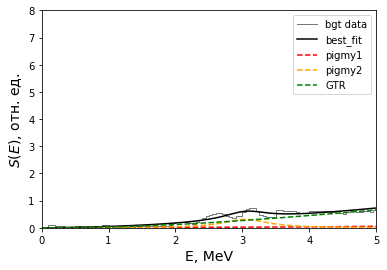

In [44]:
total_mod_comps = total_mod_result.eval_components()

#plt.figure(figsize=(13,7))
#plt.plot(data['x'].values, data['y'].values)
plt.step(x_values, y_bgt_new, 'dimgrey', linewidth=0.9, label='bgt data')
plt.plot(x_values, total_mod_result.best_fit, 'k', ls='-', label='best_fit')
plt.plot(x_values, total_mod_comps['pigmy1_'], 'red', ls='--', label='pigmy1',)
plt.plot(x_values, total_mod_comps['pigmy2_'], 'orange', ls='--', label='pigmy2')
plt.plot(x_values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.legend()


plt.xlabel('E, MeV',fontsize=14)
#plt.ylabel('S(E), 1/MeV')
plt.ylabel('$S(E)$, отн. ед.', rotation=90, fontsize=14)
plt.ylim(0,8)
plt.xlim(0,5)
#plt.show()

## Матричные элементы от ЮС

In [45]:
En = np.array([0.2, 0.54, 1.58, 1.97, 2.76, 3.08, 3.45, 6.0, 8.34, 14.8, 20.59, 20.94, \
               21.09, 21.22, 29.70])

Mn = np.array([0.0025, 0.0025, 0.01, 0.01, 0.02, 0.10, 0.01, 0.2, 1.2, 30.8, 0.5, 0.8, \
               0.5, 1.03, 6.3])

np.sum(Mn)

41.485

In [46]:
Ex = np.arange(0,40,0.01)
w = En
M_square = Mn
alpha = 0.018


norm_factors = []
for w_i,M_i in zip(w, M_square):
    y_values = breit_vigner3(Ex, 1, w_i, alpha*w_i**2)
    norm_factors.append(trapz(y_values, Ex))

plots = np.zeros((w.shape[0], Ex.shape[0]))
for idx, w_i, M_i, norm_i in zip(range(w.shape[0]), w, M_square, norm_factors):
    amplitude = M_i / norm_i
    y_values = breit_vigner3(Ex, amplitude, w_i, alpha*w_i**2)
    plots[idx] = y_values
    
summ = np.sum(plots, axis=0)

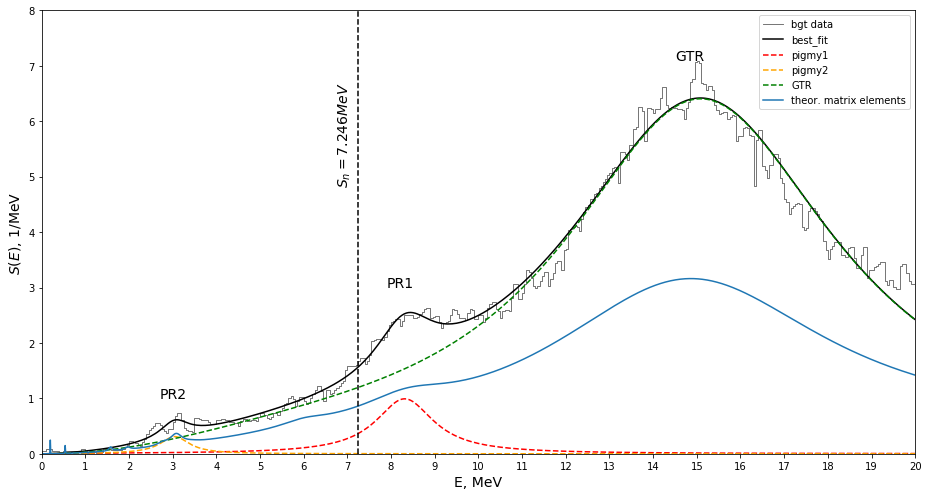

In [53]:
total_mod_comps = total_mod_result.eval_components()

plt.figure(figsize=(13,7))
#plt.plot(data['x'].values, data['y'].values)
plt.step(x_values, y_bgt_new, 'dimgrey', linewidth=0.9, label='bgt data')
plt.plot(x_values, total_mod_result.best_fit, 'k', ls='-', label='best_fit')
plt.plot(x_values, total_mod_comps['pigmy1_'], 'red', ls='--', label='pigmy1',)
plt.plot(x_values, total_mod_comps['pigmy2_'], 'orange', ls='--', label='pigmy2')
plt.plot(x_values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.plot(Ex, summ, label='theor. matrix elements')
plt.legend()
plt.axvline(S_n, c='black', ls='--',)
plt.text(S_n-0.5, 6.5, '$S_{n}=7.246 MeV$', rotation=90, fontsize=14)

plt.text(14.5, 7.1, 'GTR',  fontsize=14)
plt.text(2.7, 1.0, 'PR2',  fontsize=14)
plt.text(7.9, 3, 'PR1',  fontsize=14)

plt.xlabel('E, MeV',fontsize=14)
#plt.ylabel('S(E), 1/MeV')
plt.ylabel('$S(E)$, 1/MeV', rotation=90, fontsize=14)
plt.ylim(0,8)
plt.xlim(0,20)
plt.xticks(np.arange(0,21,1))
#plt.show()
plt.tight_layout()
plt.savefig('Xe127_decomposition_BGT.png', format='png', dpi=500)

In [48]:
output = pd.DataFrame(data={'Ex, MeV':x_values,
                            "bgt":y_bgt_new,
                            "best_fit":total_mod_result.best_fit,
                            'pr1':total_mod_comps['pigmy1_'],
                            "pr2":total_mod_comps['pigmy2_'],
                            "gtr":total_mod_comps['GTR_']})
output.head()

,"Ex, MeV",best_fit,bgt,gtr,pr1,pr2
0,0.00,0.00000,0.014032,0.00000,0.00000,0.00000
1,0.05,0.00019,0.041647,0.00007,0.00004,0.00008
2,0.10,0.00075,0.041647,0.00027,0.00014,0.00034
3,0.15,0.00171,0.089973,0.00061,0.00033,0.00077
4,0.20,0.00300,0.089973,0.00108,0.00058,0.00134


In [49]:
x_values

array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95,  1.  ,  1.05,  1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,
        1.35,  1.4 ,  1.45,  1.5 ,  1.55,  1.6 ,  1.65,  1.7 ,  1.75,
        1.8 ,  1.85,  1.9 ,  1.95,  2.  ,  2.05,  2.1 ,  2.15,  2.2 ,
        2.25,  2.3 ,  2.35,  2.4 ,  2.45,  2.5 ,  2.55,  2.6 ,  2.65,
        2.7 ,  2.75,  2.8 ,  2.85,  2.9 ,  2.95,  3.  ,  3.05,  3.1 ,
        3.15,  3.2 ,  3.25,  3.3 ,  3.35,  3.4 ,  3.45,  3.5 ,  3.55,
        3.6 ,  3.65,  3.7 ,  3.75,  3.8 ,  3.85,  3.9 ,  3.95,  4.  ,
        4.05,  4.1 ,  4.15,  4.2 ,  4.25,  4.3 ,  4.35,  4.4 ,  4.45,
        4.5 ,  4.55,  4.6 ,  4.65,  4.7 ,  4.75,  4.8 ,  4.85,  4.9 ,
        4.95,  5.  ,  5.05,  5.1 ,  5.15,  5.2 ,  5.25,  5.3 ,  5.35,
        5.4 ,  5.45,  5.5 ,  5.55,  5.6 ,  5.65,  5.7 ,  5.75,  5.8 ,
        5.85,  5.9 ,  5.95,  6.  ,  6.05,  6.1 ,  6.15,  6.2 ,  6.25,
        6.3 ,  6.35,

In [50]:
output.to_excel('127Xe_bgt_decomp.xls', index=False)